In [1]:
from torchvision.datasets import MNIST

In [2]:
mnist_train = MNIST('./mnist', download=True)
mnist_text = MNIST('./mnist', download=True, train=False)

In [3]:
mnist_train

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./mnist
    Split: Train

In [4]:
mnist_train[0]

(<PIL.Image.Image image mode=L size=28x28>, 5)

In [5]:
mnist_train[0][0]

In [6]:
import numpy as np

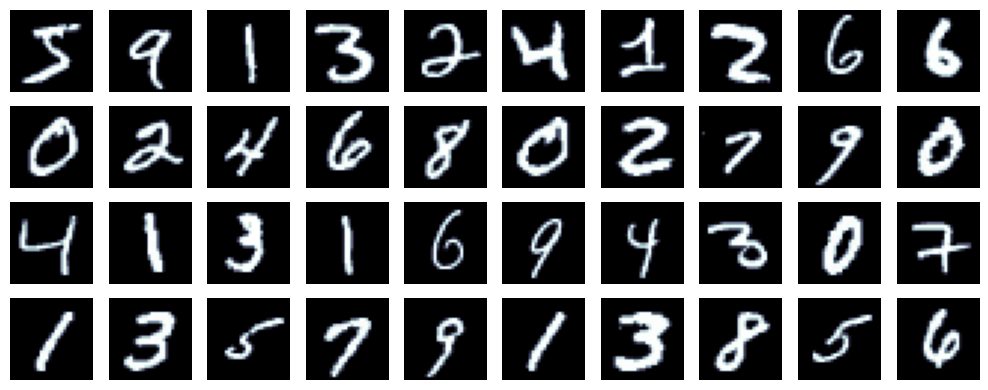

In [7]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(4, 10, figsize=(10, 4))

for i, (image, c) in enumerate(mnist_train):
  if i >= 40:
    break
  ax = axes[i% 4, i //4]
  plt.sca(ax)
  plt.imshow(image, cmap = 'bone')
  plt.axis('off')
plt.tight_layout()
plt.show()

In [8]:
import torch
import torchvision
import torchvision.transforms as transforms

# PyTorch TensorBoard support
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime

transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
    transforms.Lambda(lambda x: torch.flatten(x))
    ])

# Create datasets for training & validation, download if necessary
training_set = MNIST('./mnist', train=True, transform=transform, download=True)
validation_set = MNIST('./mnist', train=False, transform=transform, download=True)

training_loader = torch.utils.data.DataLoader(training_set, batch_size=8, shuffle=True,
                                              num_workers=4, pin_memory=True)
validation_loader = torch.utils.data.DataLoader(validation_set, batch_size=4, shuffle=False)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [9]:
for b in training_loader:
  break
b

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[tensor([[-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         ...,
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.]]),
 tensor([4, 2, 8, 5, 0, 6, 3, 4])]

In [10]:
b[0].shape, b[1].shape

(torch.Size([8, 784]), torch.Size([8]))

In [11]:
import torch.nn as nn
import torch.nn.functional as F

# PyTorch models inherit from torch.nn.Module
class MNISTClassifier(nn.Module):
    def __init__(self):
        super(MNISTClassifier, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(784, 128),
            nn.Sigmoid(),
            nn.Linear(128, 128),
            nn.Sigmoid(),
            nn.Linear(128, 10)

        )

    def forward(self, x):
        x = self.layers(x)
        return x

model = MNISTClassifier()
model = model.cuda()

In [12]:
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [13]:
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
writer = SummaryWriter('runs/fashion_trainer_{}'.format(timestamp))
epoch_number = 0

EPOCHS = 5

best_vloss = 1_000_000.

for epoch in range(EPOCHS):
    print('EPOCH {}:'.format(epoch_number + 1))

    # Make sure gradient tracking is on, and do a pass over the data
    model.train(True)
    running_loss = 0.
    last_loss = 0.

    for i, (inputs, labels) in enumerate(training_loader):
        inputs, labels = inputs.cuda(), labels.cuda()

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
        # Gather data and report
        running_loss += loss.item()
        if i % 1000 == 999:
            avg_loss = running_loss / 1000 # loss per batch
            print('  batch {} loss: {}'.format(i + 1, avg_loss))
            tb_x = epoch * len(training_loader) + i + 1
            writer.add_scalar('Loss/train', avg_loss, tb_x)
            running_loss = 0.

    running_vloss = 0.0
    # Set the model to evaluation mode, disabling dropout and using population
    # statistics for batch normalization.
    model.eval()

    # Disable gradient computation and reduce memory consumption.
    with torch.no_grad():
        for i, (x, y) in enumerate(validation_loader):
            x, y = x.cuda(), y.cuda()
            outputs = model(x)
            loss = loss_fn(outputs, y)
            running_vloss += loss

    avg_vloss = running_vloss / (i + 1)
    print('LOSS train {} valid {}'.format(avg_loss, avg_vloss))

    # Log the running loss averaged per batch
    # for both training and validation
    writer.add_scalars('Training vs. Validation Loss',
                    { 'Training' : avg_loss, 'Validation' : avg_vloss },
                    epoch_number + 1)
    writer.flush()

    # Track best performance, and save the model's state
    if avg_vloss < best_vloss:
        best_vloss = avg_vloss
        model_path = 'model_{}_{}'.format(timestamp, epoch_number)
        torch.save(model.state_dict(), model_path)

    epoch_number += 1

EPOCH 1:
  batch 1000 loss: 2.2999972298145295
  batch 2000 loss: 2.2480596506595614
  batch 3000 loss: 2.0978193123340607
  batch 4000 loss: 1.699015332877636
  batch 5000 loss: 1.2674562631845474
  batch 6000 loss: 1.0116713500618935
  batch 7000 loss: 0.8657294512689113
LOSS train 0.8657294512689113 valid 0.7380089163780212
EPOCH 2:
  batch 1000 loss: 0.713982570245862
  batch 2000 loss: 0.6327727214097977
  batch 3000 loss: 0.5660283377617598
  batch 4000 loss: 0.5299592360779644
  batch 5000 loss: 0.4789209542125463
  batch 6000 loss: 0.46308855643868446
  batch 7000 loss: 0.4324110864885151
LOSS train 0.4324110864885151 valid 0.4053175449371338
EPOCH 3:
  batch 1000 loss: 0.40725322073325515
  batch 2000 loss: 0.4025811251476407
  batch 3000 loss: 0.36588458162918686
  batch 4000 loss: 0.37509246183745565
  batch 5000 loss: 0.3720445149261504
  batch 6000 loss: 0.3575512480288744
  batch 7000 loss: 0.3326311229094863
LOSS train 0.3326311229094863 valid 0.325084388256073
EPOCH 4:


In [14]:
vacc = 0
with torch.no_grad():
    for i, (x, y) in enumerate(validation_loader):
        x, y = x.cuda(), y.cuda()
        outputs = model(x)
        vacc += torch.sum(outputs.argmax(dim=1) == y).item()
print(vacc / len(validation_set))

0.9305
